## Домашнее задание

1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

In [2]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

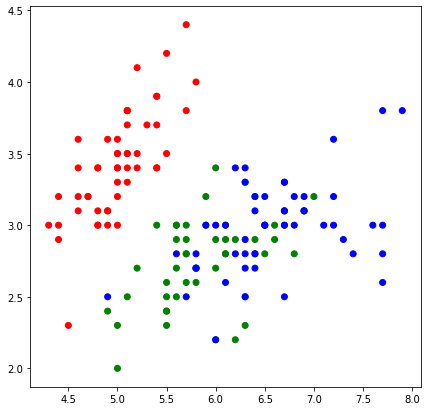

In [5]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [6]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [22]:
def knn(x_train, y_train, x_test, k, q=0.5):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):  
            distance = e_metrics(x, x_train[i])
            test_distances.append((distance, y_train[i]))
        
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Реализем метод экспонинциально взвешенных ближайших соседей
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += q**d[0]
            
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [23]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [24]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

In [25]:
k = 3

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 3: 0.733


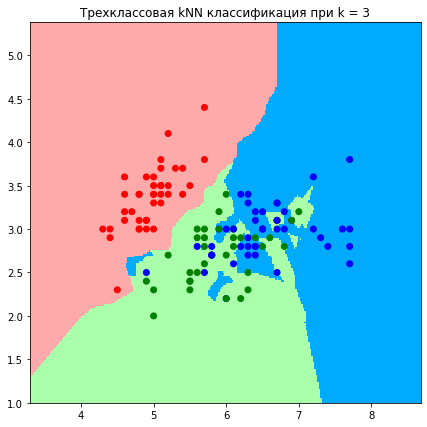

In [26]:
get_graph(X_train, y_train, k)

In [27]:
k = 10

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 10: 0.867


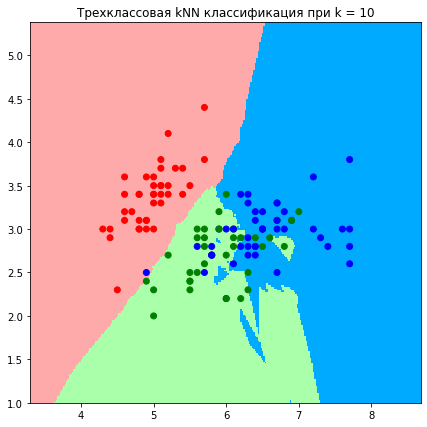

In [28]:
get_graph(X_train, y_train, k)

2*. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить 
график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

In [29]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=100, random_state=1)

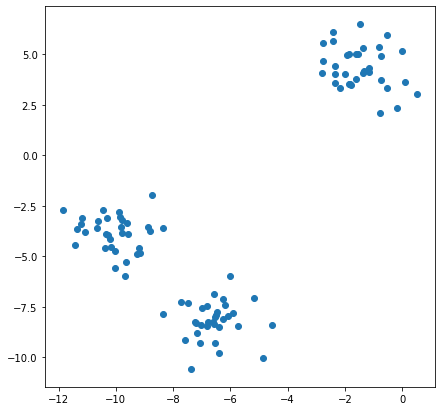

In [30]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

In [49]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [50]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()

In [56]:
def get_msd_inside(centroids, classes_dict):
    msd_inside = 0
    
    for i in range(len(classes_dict)):
        dist_sum = 0
        for item in classes_dict[i]:
            dist = e_metrics(item, centroids[i])
            dist_sum += dist * dist
        msd_inside += dist_sum / len(classes_dict[i])
    
    return msd_inside

In [57]:
# определим максимальное количество итераций
max_iterations = 10

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

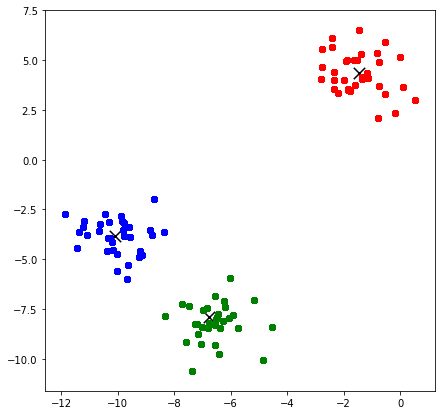

In [58]:
centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

In [64]:
max_iterations = 100
min_distance = 1e-4
msd_list = []

for k in range(10):
    centroids, clusters = kmeans(X, k+1, max_iterations, min_distance)
    curr_msd = get_msd_inside(centroids, clusters)
    msd_list.append(curr_msd)

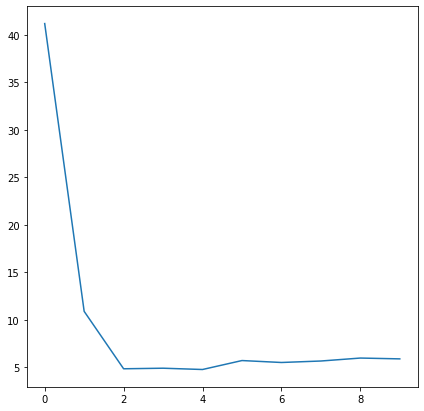

In [66]:
plt.figure(figsize=(7,7))
x = list(range(len(msd_list)))
plt.plot(x, msd_list)

Видно, что среднее квадратичное внутрикластерное расстояние сильно упало, как только модель быоа разделена на 3 класса. Далее оно начинает несильно колебаться около совего минимума. Если я правильно понимаю, чтобы в полной мере оценить качество класетризации, необходимо к этой оценке добавить еще межкластерное расстояние, так как если смотреть только на внутри- можно подумать что лучшее разделение получается при 5 классах (минимум метрики). Межкластерное расстояние скорее всего даст понять, что при k=5 эта метрика далека от своего максимума (а ее необходимо максимизировать) и оптимальным выбором станет k=3.